# Barcode plots of bitcoin random graphs

In [1]:
# L0 barcode graph for random graph for both networks

import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
alpha_df = pd.read_csv('../../soc-sign-bitcoinalpha.csv', header=None)
alpha_df.columns = ['source', 'target', 'weight', 'timestamp']

OTC_df = pd.read_csv('../../soc-sign-bitcoinotc.csv', header=None)
OTC_df.columns = ['source', 'target', 'weight', 'timestamp']

# Alpha Graph Construction
alpha_G = nx.DiGraph()
for src, tgt, _, _ in zip(alpha_df['source'], alpha_df['target'], alpha_df['weight'], alpha_df['timestamp']):
    u = int(src)
    v = int(tgt)
    alpha_G.add_edge(u, v)  # no weight for laplcian computation

# OTC graph construction
otc_G = nx.DiGraph()
for src, tgt, _, _ in zip(OTC_df['source'], OTC_df['target'], OTC_df['weight'], OTC_df['timestamp']):
    u = int(src)
    v = int(tgt)
    otc_G.add_edge(u, v)  # no weight for laplcian computation

# Convert to undirected for Laplacian
alpha_undirected = alpha_G.to_undirected()
otc_undirected = otc_G.to_undirected()

### Plotting only negative weights

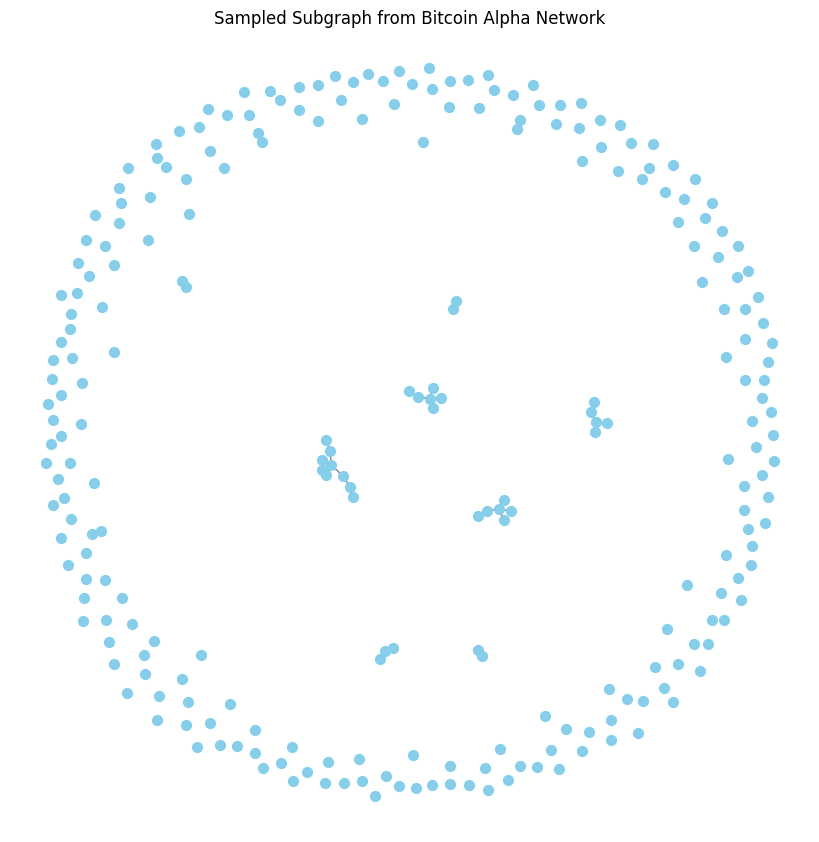

In [3]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs

# Load Alpha dataset
alpha_df = pd.read_csv('../../soc-sign-bitcoinalpha.csv', header=None)
alpha_df.columns = ['source', 'target', 'weight', 'timestamp']

# Create directed graph with only non-negative edges
alpha_G_negative = nx.DiGraph()
edge_timestamps = {}

for src, tgt, weight, ts in zip(alpha_df['source'], alpha_df['target'], alpha_df['weight'], alpha_df['timestamp']):
    if weight >= 0:
        u, v = int(src), int(tgt)
        alpha_G_negative.add_edge(u, v)
        edge_timestamps[(u, v)] = int(ts)

# Convert to undirected graph for L1 construction
G_negative = alpha_G_negative.to_undirected()

# Sample a subset of nodes (e.g., 100 random nodes)
sample_size = 250
sampled_nodes = np.random.choice(G_negative.nodes(), size=sample_size, replace=False)
subG = G_negative.subgraph(sampled_nodes)

# Plot the sampled subgraph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(subG, seed=42)  # spring layout for better spacing
nx.draw(subG, pos, with_labels=False, node_size=50, node_color='skyblue', edge_color='gray')
plt.title("Sampled Subgraph from Bitcoin Alpha Network")
plt.show()

In [12]:
from collections import Counter
from networkx.algorithms.clique import find_cliques

# Get all cliques in G_negative
all_cliques = list(find_cliques(G_negative))
num_nodes = G_negative.number_of_nodes()

# Count cliques by size
clique_sizes = Counter(len(clique) for clique in all_cliques)

# Extract simplex counts
simplices = {
    "2-simplex (triangle)": clique_sizes[3],
    "3-simplex (4 nodes)": clique_sizes[4],
    "4-simplex (5 nodes)": clique_sizes[5],
    "5-simplex (6 nodes)": clique_sizes[6],
}

# Print results
for k, v in simplices.items():
    print(f"{k}: {v}")

print("\nSimplex counts scaled by number of nodes:")
for k, v in simplices.items():
    scaled = v / num_nodes
    print(f"{k}: {scaled:.4f} per node")


2-simplex (triangle): 2501
3-simplex (4 nodes): 1586
4-simplex (5 nodes): 1214
5-simplex (6 nodes): 968

Simplex counts scaled by number of nodes:
2-simplex (triangle): 0.6791 per node
3-simplex (4 nodes): 0.4306 per node
4-simplex (5 nodes): 0.3296 per node
5-simplex (6 nodes): 0.2628 per node


In [8]:
import gudhi as gd
import numpy as np
import networkx as nx

# Compute shortest path distance matrix for subgraph
largest_cc = max(nx.connected_components(G_negative), key=len)
alpha_G_negative_lcc = alpha_G_negative.subgraph(largest_cc).copy()

dist_matrix = nx.floyd_warshall_numpy(alpha_G_negative_lcc)
dist_array = np.array(dist_matrix)

# Create Rips complex and compute persistence
rips_complex = gd.RipsComplex(distance_matrix=dist_array)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
simplex_tree.compute_persistence()

# Count number of finite H1 intervals (Betti-1)
betti_1 = sum(1 for dim, pair in simplex_tree.persistence() if dim == 1 and np.isfinite(pair[1]))

print("Betti number β₁ (number of 1D holes):", betti_1)


: 

In [ ]:
import gudhi as gd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd

# Load full dataset
df = pd.read_csv('../../soc-sign-bitcoinalpha.csv', header=None)
df.columns = ['source', 'target', 'weight', 'timestamp']

# Keep only non-negative edges
df = df[df['weight'] >= 0]

# Define time bins
time_bins = np.linspace(df['timestamp'].min(), df['timestamp'].max(), 10, dtype=int)

# Barcode plot setup
plt.figure(figsize=(12, 6))
h1_idx = 0

for i in range(len(time_bins) - 1):
    t_start, t_end = time_bins[i], time_bins[i+1]
    df_sub = df[(df['timestamp'] >= t_start) & (df['timestamp'] < t_end)]

    G = nx.Graph()
    for u, v in zip(df_sub['source'], df_sub['target']):
        G.add_edge(int(u), int(v))

    if G.number_of_edges() == 0:
        continue

    largest_cc = max(nx.connected_components(G), key=len)
    subG = G.subgraph(largest_cc).copy()

    try:
        dist_matrix = nx.floyd_warshall_numpy(subG)
    except:
        continue  # Skip if any computation fails

    dist_array = np.array(dist_matrix)
    rips = gd.RipsComplex(distance_matrix=dist_array)
    st = rips.create_simplex_tree(max_dimension=2)
    diag = st.persistence()

    for dim, (birth, death) in diag:
        if dim == 1:
            plt.hlines(y=h1_idx, xmin=birth, xmax=death, color='blue')
            h1_idx += 1

plt.xlabel("Filtration Value (Distance)")
plt.ylabel("H1 Feature Index")
plt.title("Vietoris–Rips Barcode (H1) Over Time Windows")
plt.show()

In [6]:
import networkx as nx
import pandas as pd
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt

# Generate random graph (Erdős–Rényi or config model)
num_nodes = alpha_G.number_of_nodes()
num_edges = alpha_G.number_of_edges()
random_G = nx.gnm_random_graph(num_nodes, num_edges, seed=42)

# Randomly assign timestamps
edge_list = list(random_G.edges())
timestamps = np.random.uniform(low=1289243140, high=1453684323, size=len(edge_list))
timestamped_edges = list(zip([e[0] for e in edge_list], [e[1] for e in edge_list], timestamps))

# Sort edges by time
timestamped_edges.sort(key=lambda x: x[2])


In [7]:
# Create list of all vertices
all_nodes = list(random_G.nodes())
simplicial_complex = gd.SimplexTree()

# Add all nodes at time 0
for node in all_nodes:
    simplicial_complex.insert([node], filtration=0)

# Add edges based on timestamp
for u, v, t in timestamped_edges:
    simplicial_complex.insert([u, v], filtration=t)

# Compute persistent homology
simplicial_complex.initialize_filtration()
diag = simplicial_complex.persistence(homology_coeff_field=2, persistence_dim_max=True)


/var/folders/wd/y1121gj51b71_ydlgt9qgvc00000gn/T/ipykernel_68009/303391912.py:14: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  simplicial_complex.initialize_filtration()


/Users/matthewzhang/190J-Project/.venv/lib/python3.9/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")
/Users/matthewzhang/190J-Project/.venv/lib/python3.9/site-packages/gudhi/persistence_graphical_tools.py:85: UserWarning: There are 24187 intervals given as input, whereas max_intervals is set to 20000.
  warnings.warn(


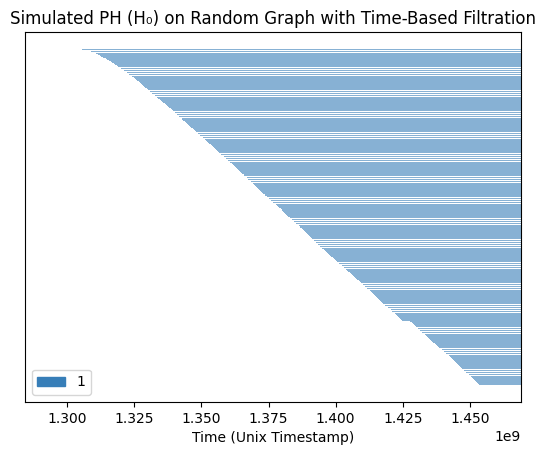

In [7]:
import gudhi as gd
import matplotlib.pyplot as plt

# Compute and plot barcode (H0 only)
gd.plot_persistence_barcode(diag, legend=True)
plt.title("Simulated PH (H₀) on Random Graph with Time-Based Filtration")
plt.xlabel("Time (Unix Timestamp)")
plt.show()



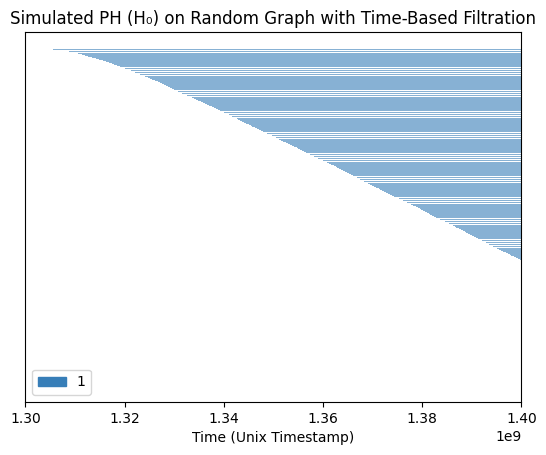

In [8]:
gd.plot_persistence_barcode(diag, legend=True)
plt.title("Simulated PH (H₀) on Random Graph with Time-Based Filtration")
plt.xlabel("Time (Unix Timestamp)")

# Set x-axis limits to zoom in
plt.xlim(1.3e9, 1.4e9)  # adjust these as needed

plt.show()

# H1 Barcode for random graphs

/Users/matthewzhang/190J-Project/.venv/lib/python3.9/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


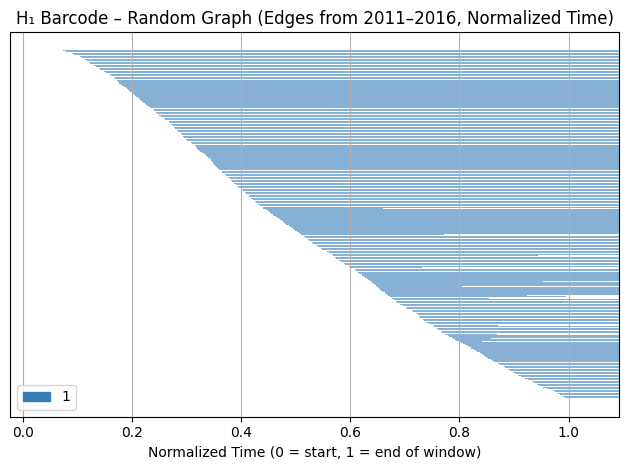

In [9]:
import networkx as nx
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt

# Step 1: Generate large random graph
G = nx.erdos_renyi_graph(n=400, p=0.12, seed=42)
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

# Step 2: Assign random timestamps (wide range)
full_start = int(1.200e9)  # ~2008
full_end = int(1.700e9)    # ~2025
for u, v in G.edges():
    G[u][v]['timestamp'] = np.random.randint(full_start, full_end)

# Step 3: Define visible time window
view_start = int(1.300e9)  # 2011
view_end = int(1.475e9)    # 2016

# Step 4: Filter edges within time window and normalize timestamps to [0, 1]
nodes = list(G.nodes())
idx_map = {node: i for i, node in enumerate(nodes)}
n = len(nodes)
dist_matrix = np.full((n, n), np.inf)

# Get only edges within the viewable time window
valid_edges = [(u, v, data['timestamp']) for u, v, data in G.edges(data=True) if view_start <= data['timestamp'] <= view_end]
if not valid_edges:
    raise ValueError("No edges found in the specified time window.")

timestamps = [ts for _, _, ts in valid_edges]
ts_min, ts_max = min(timestamps), max(timestamps)

# Fill the distance matrix with normalized timestamps
for u, v, ts in valid_edges:
    i, j = idx_map[u], idx_map[v]
    norm_ts = (ts - ts_min) / (ts_max - ts_min)
    dist_matrix[i][j] = norm_ts
    dist_matrix[j][i] = norm_ts

# Step 5: Rips complex and persistence
rips = gd.RipsComplex(distance_matrix=dist_matrix)
st = rips.create_simplex_tree(max_dimension=2)
diag = st.persistence(homology_coeff_field=2)

# Step 6: Extract and plot H1 barcode
h1_diag = [pair for pair in diag if pair[0] == 1]

gd.plot_persistence_barcode(h1_diag)
plt.title("H₁ Barcode – Random Graph (Edges from 2011–2016, Normalized Time)")
plt.xlabel("Normalized Time (0 = start, 1 = end of window)")
plt.grid(True)
plt.tight_layout()
plt.show()


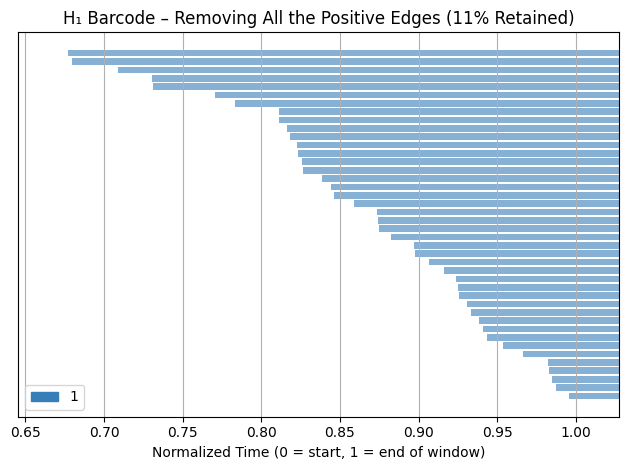

In [10]:
import random 

retain_fraction = 0.11 # keep only the 11 negative weights
num_retain = int(len(valid_edges) * retain_fraction)
random.seed(42)  # still reproducible
reduced_edges = random.sample(valid_edges, num_retain)

# Rebuild the distance matrix with reduced edges
reduced_dist_matrix = np.full((n, n), np.inf)
for u, v, ts in reduced_edges:
    i, j = idx_map[u], idx_map[v]
    norm_ts = (ts - ts_min) / (ts_max - ts_min)
    reduced_dist_matrix[i][j] = norm_ts
    reduced_dist_matrix[j][i] = norm_ts

# New Rips complex and H₁ barcode
reduced_rips = gd.RipsComplex(distance_matrix=reduced_dist_matrix)
reduced_st = reduced_rips.create_simplex_tree(max_dimension=2)
reduced_diag = reduced_st.persistence(homology_coeff_field=2)

# Filter H₁
reduced_h1_diag = [pair for pair in reduced_diag if pair[0] == 1]

# Plot the new barcode
gd.plot_persistence_barcode(reduced_h1_diag)
plt.title("H₁ Barcode – Removing All the Positive Edges (11% Retained)")
plt.xlabel("Normalized Time (0 = start, 1 = end of window)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
reduced_h1_diag = [pair for pair in reduced_diag if pair[0] == 1]
print("Betti number β₁ (number of 1D holes after filtering):", len(reduced_h1_diag))

# Calcuate the simplexes count 
from collections import Counter

# Count simplices in the reduced Rips complex
simplex_counts = Counter()

for simplex, _ in reduced_st.get_simplices():
    dim = len(simplex) - 1
    simplex_counts[dim] += 1

# Print the number of 2- to 5-simplices (i.e., cliques of size 3 to 6)
print("\nSimplex counts in reduced random Rips complex:")
for k in range(3, 6):  # 2-simplex to 5-simplex
    print(f"{k}-simplex (clique of {k+1} nodes): {simplex_counts[k]}")



Betti number β₁ (number of 1D holes after filtering): 42

Simplex counts in reduced random Rips complex:
3-simplex (clique of 4 nodes): 0
4-simplex (clique of 5 nodes): 0
5-simplex (clique of 6 nodes): 0


# H1 barplot for actaul bitcoin networks

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
import pandas as pd
def generate_h1_barcode_over_time_fast(df, name, num_bins=6):
    # Smarter time binning using quantiles
    time_bins = np.quantile(df['timestamp'], np.linspace(0, 1, num_bins + 1)).astype(int)

    for i in range(len(time_bins) - 1):
        t_start, t_end = time_bins[i], time_bins[i + 1]
        df_sub = df[(df['timestamp'] >= t_start) & (df['timestamp'] < t_end)]

        # Build graph
        G = nx.Graph()
        G.add_edges_from(zip(df_sub['source'], df_sub['target']))

        if G.number_of_edges() == 0:
            continue

        # Use largest connected component only
        largest_cc = max(nx.connected_components(G), key=len)
        subG = G.subgraph(largest_cc).copy()

        # Use all-pairs Dijkstra (faster on sparse graphs)
        nodes = list(subG.nodes())
        node_idx = {node: i for i, node in enumerate(nodes)}
        n = len(nodes)
        dist_matrix = np.full((n, n), np.inf)

        for u in nodes:
            lengths = nx.single_source_shortest_path_length(subG, u)
            for v, d in lengths.items():
                i, j = node_idx[u], node_idx[v]
                dist_matrix[i][j] = d

        # Build Rips complex
        rips_complex = gd.RipsComplex(distance_matrix=dist_matrix, max_edge_length=np.inf)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
        diag = simplex_tree.persistence(homology_coeff_field=2, min_persistence=0)

        # Extract H1 features
        h1_features = [pair[1] for pair in diag if pair[0] == 1]

        # Plot H1 barcode
        if h1_features:
            plt.figure(figsize=(8, 2))
            for j, (birth, death) in enumerate(h1_features):
                plt.plot([birth, death], [j, j], lw=2)
            plt.xlabel("Filtration Scale")
            plt.title(f"{name} H₁ Barcode | {t_start} – {t_end}")
            plt.yticks([])
            plt.grid(True)
            plt.tight_layout()
            plt.show()

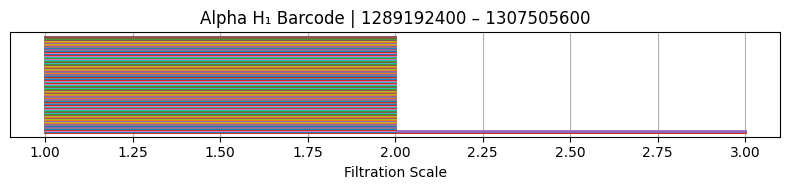

In [ ]:
generate_h1_barcode_over_time_fast(alpha_df, "Alpha")
# f

# K Cliques

In [13]:
import networkx as nx
from networkx.algorithms.clique import enumerate_all_cliques

def count_k_cliques(G, k):
    return sum(1 for clique in enumerate_all_cliques(G) if len(clique) == k)

def estimate_p(G):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    max_edges = n * (n - 1) / 2
    return m / max_edges if max_edges > 0 else 0

def run_k_clique_comparison(G_real, name):
    n = G_real.number_of_nodes()
    p = estimate_p(G_real)
    G_rand = nx.erdos_renyi_graph(n=n, p=p, seed=42)

    print(f"\n{name} (n={n}, p≈{p:.4f}):")
    for k in range(2, 6):
        real_count = count_k_cliques(G_real, k)
        rand_count = count_k_cliques(G_rand, k)
        print(f"  k={k}-cliques → real: {real_count} | random: {rand_count}")
        
def run_k_clique_comparison_scaled(G_real, name):
    n = G_real.number_of_nodes()
    p = estimate_p(G_real)
    G_rand = nx.erdos_renyi_graph(n=n, p=p, seed=42)

    print(f"\n{name} (n={n}, p≈{p:.4f}):")
    for k in range(2, 6):
        real_count = count_k_cliques(G_real, k)
        rand_count = count_k_cliques(G_rand, k)
        scaled_real = real_count / n
        scaled_rand = rand_count / n
        print(f"  k={k}-cliques → real: {real_count} ({scaled_real:.4f}/node) | "
              f"random: {rand_count} ({scaled_rand:.4f}/node)")

# Make sure graphs are undirected
alpha_undirected = alpha_G.to_undirected()
otc_undirected = otc_G.to_undirected()

# Run for both graphs
run_k_clique_comparison(alpha_undirected, "Bitcoin Alpha")
run_k_clique_comparison(otc_undirected, "Bitcoin OTC")

run_k_clique_comparison_scaled(alpha_undirected, "Bitcoin Alpha")
run_k_clique_comparison_scaled(otc_undirected, "Bitcoin OTC")



Bitcoin Alpha (n=3783, p≈0.0020):
  k=2-cliques → real: 14124 | random: 13855
  k=3-cliques → real: 22153 | random: 73
  k=4-cliques → real: 30948 | random: 0
  k=5-cliques → real: 31457 | random: 0

Bitcoin OTC (n=5881, p≈0.0012):
  k=2-cliques → real: 21492 | random: 21206
  k=3-cliques → real: 33493 | random: 66
  k=4-cliques → real: 48390 | random: 0
  k=5-cliques → real: 52481 | random: 0

Bitcoin Alpha (n=3783, p≈0.0020):
  k=2-cliques → real: 14124 (3.7335/node) | random: 13855 (3.6624/node)
  k=3-cliques → real: 22153 (5.8559/node) | random: 73 (0.0193/node)
  k=4-cliques → real: 30948 (8.1808/node) | random: 0 (0.0000/node)
  k=5-cliques → real: 31457 (8.3154/node) | random: 0 (0.0000/node)

Bitcoin OTC (n=5881, p≈0.0012):
  k=2-cliques → real: 21492 (3.6545/node) | random: 21206 (3.6058/node)
  k=3-cliques → real: 33493 (5.6951/node) | random: 66 (0.0112/node)
  k=4-cliques → real: 48390 (8.2282/node) | random: 0 (0.0000/node)
  k=5-cliques → real: 52481 (8.9238/node) | rand